In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

In [10]:
sw_indo = stopwords.words("indonesian") + list(punctuation) #buang puctuation

# bisa jadi punctuation yang di anggap sebagai stopword dalam sentiment 
# jika ada tanda seru tandanya sentiment negatif, makanya stopword 
# tanda seru jangan dihilangkan

### Import Data

In [11]:
df = pd.read_csv("./data/gojek_review_sentiment.csv")
df.head()

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive


In [12]:
df.rate.value_counts()

negative    1061
positive     721
Name: rate, dtype: int64

In [14]:
# cek normalisasi keseimbangannya
df.rate.value_counts(normalize=True)

# oleh karena itu, jika masih seimbang, boleh hanya menggunakan akurasi saja tanpa menggunakan klasifikasi report seperti,
# tidak usah pakai f1-score dll, jika tidak balance menggunakan parameter pengukuran lain
# agar lebih fair

negative    0.595398
positive    0.404602
Name: rate, dtype: float64

### Dataset Splitting - pilih stratify (karna ini klasifikasi)

In [17]:
X = df.review
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425,), (357,), (1425,), (357,))

### Training - SVM - RandomSearchCV

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

# karna data text maka harus ekstrak dulu text tersebut ke vektor, itu sebabnya
# alasan menggunakan fitur  sentence ke vec (bow, if-idf) atau word ke vec (word2vec, fasttext)
from sklearn.feature_extraction.text import CountVectorizer # ini pake bow
from sklearn.feature_extraction.text import TfidfVectorizer # ini pake tfidf

In [20]:
pipeline = Pipeline([
    ('prep', CountVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.4min finished
C:\Users\Niken Amelia\.conda\envs\jcop_wv\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['--', '``'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Niken Amelia\.conda\envs\jcop_wv\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 4.418441521199726, 'algo__gamma': 0.010547383621352041}
0.9312280701754386 0.8533333333333333 0.8571428571428571


### Evaluation

In [21]:
from jcopml.plot import plot_confusion_matrix

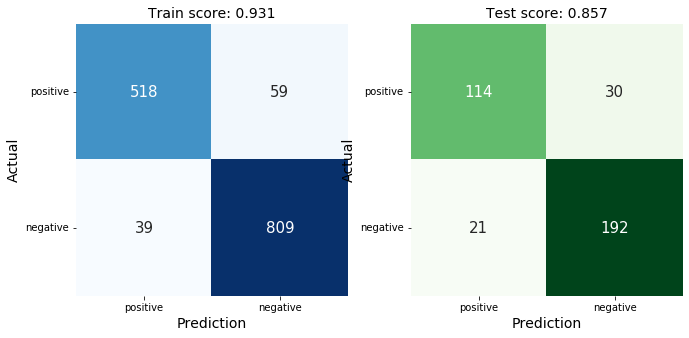

In [22]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)